# Installs

In [10]:
!pip install torch transformers jaxtyping rich fancy_einsum wandb

# ImageNet Model

In [1]:
from transformers import AutoImageProcessor, ViTForImageClassification
from transformer_lens.HookedViT import HookedViT

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch32-224-in21k")
hf_model = ViTForImageClassification.from_pretrained("google/vit-base-patch32-224-in21k").to("cuda")
tl_model = HookedViT.from_pretrained("google/vit-base-patch32-224-in21k").to("cuda")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Moving model to device:  cuda
Loaded pretrained model google/vit-base-patch32-224-in21k into HookedTransformer
Moving model to device:  cuda


In [2]:
import torch

hf_model.load_state_dict(torch.load("../models/imagenet_vit32/oflqncyh.pth"))

<All keys matched successfully>

In [3]:
from transformer_lens.loading_from_pretrained import convert_vit_weights

state_dict = convert_vit_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'blocks.9.attn.mask', 'blocks.9.attn.IGNORE', 'blocks.10.attn.mask', 'blocks.10.attn.IGNORE', 'blocks.11.attn.mask', 'blocks.11.attn.IGNORE'], unexpected_keys=[])

## Load Data

In [6]:
im_path_same = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/same/0.png"
im_path_diff = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different/0.png"
im_path_diff_shape = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-shape/0.png"
im_path_diff_texture = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-texture/0.png"

In [7]:
from PIL import Image
import numpy as np

In [8]:
same = Image.open(im_path_same)
diff = Image.open(im_path_diff)
corrupt_shape = Image.open(im_path_diff_shape)
corrupt_texture = Image.open(im_path_diff_texture)

same = image_processor.preprocess(np.array(same, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
diff = image_processor.preprocess(np.array(diff, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_shape = image_processor.preprocess(np.array(corrupt_shape, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_texture = image_processor.preprocess(np.array(corrupt_texture, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

In [9]:
torch.set_grad_enabled(False)

## Activation Patching

In [10]:
import transformer_lens.patching as patching

In [11]:
print(f"Same Logits: {tl_model(same)}")
print(f"Different Logits: {tl_model(diff)}")
print(f"Different-Shape Logits: {tl_model(corrupt_shape)}")
print(f"Different-Texture Logits: {tl_model(corrupt_texture)}")

Same Logits: tensor([[-2.9909,  2.9718]], device='cuda:0')
Different Logits: tensor([[ 2.9905, -2.9528]], device='cuda:0')
Different-Shape Logits: tensor([[ 2.9623, -2.9117]], device='cuda:0')
Different-Texture Logits: tensor([[ 2.9773, -2.9472]], device='cuda:0')


### Logit Difference Score

In [12]:
same_logits, same_cache = tl_model.run_with_cache(same)
diff_logits, diff_cache = tl_model.run_with_cache(diff)
_, diff_shape_cache = tl_model.run_with_cache(corrupt_shape)
_, diff_texture_cache = tl_model.run_with_cache(corrupt_texture)

In [13]:
num_patches = same_cache['embed.hook_embed'].shape[1]

In [14]:
def get_score(patch_logits, same_logits=same_logits, diff_logits=diff_logits):
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    diff_logits_diff = diff_logits[0, 1] - diff_logits[0, 0]
    patched_logits_diff = patch_logits[0, 1] - patch_logits[0, 0]

    return 2 * (patched_logits_diff - diff_logits_diff)/(same_logits_diff - diff_logits_diff) - 1

### Residual Stream Patching

In [15]:
from jaxtyping import Float
from functools import partial
import transformer_lens.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
def patch_residual_component(
    target_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    source_cache,
):
    target_residual_component[:, pos, :] = source_cache[hook.name][:, pos, :]
    return target_residual_component

def resid_patching(target_image, title, source_cache):
    patched_residual_stream_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for position in range(num_patches):
            hook_fn = partial(patch_residual_component, pos=position, source_cache=source_cache)
            patched_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )
            patched_residual_stream_diff[layer, position] = get_score(patched_logits)
    s =sns.heatmap(patched_residual_stream_diff.cpu())
    s.set_title(title)
    s.set(xlabel='Stream', ylabel='Layer')

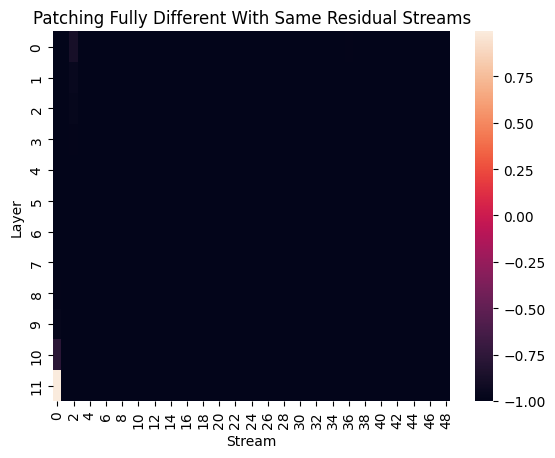

In [32]:
resid_patching(diff, "Patching Fully Different With Same Residual Streams", same_cache)

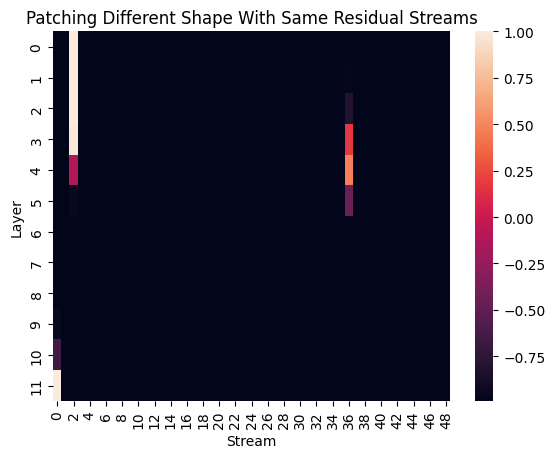

In [18]:
resid_patching(corrupt_shape, "Patching Different Shape With Same Residual Streams", same_cache)

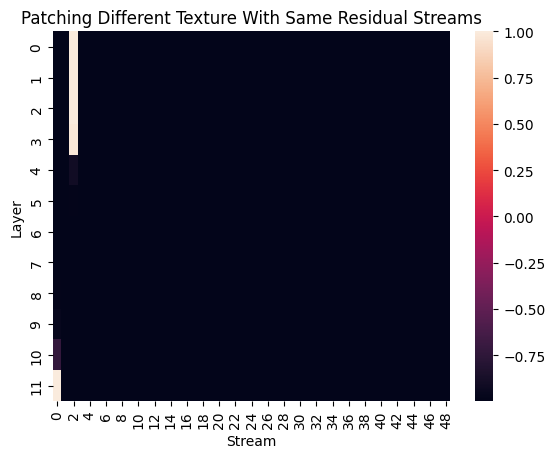

In [19]:
resid_patching(corrupt_texture, "Patching Different Texture With Same Residual Streams", same_cache)

## Linear Subspace Analysis

### Texture

Experimental Design

Fix Object 1 as (S, T), Generate Object 2 with (S, T')

Then, create images with (S, T), (S'', T') for all possible S''
Repeat for (S, T), (S'', T) for all possible S''

Experiment: Average the 16 vectors in both conditions to create a T' vector and T vector.
T' vector = mean(S) + T' / T vector = mean(S) + T
See if you can subtract the T' vector and add the T vector from the residual stream of Object 2
to change the model's decision from Different to Same.
-mean(S) - T' + mean(S) + T  should remove T' and add T if Texture exists in a different linear subspace as Shape

In [ ]:
import os
import pickle as pkl

torch.set_grad_enabled(False)

set_dir = "../stimuli/Interventions/Texture_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

texture_1_group = []
texture_2_group = []

for i in range(16):
    path = f"Texture_1_{i}.png"
    texture_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Texture_2_{i}.png"
    texture_2_group.append(Image.open(os.path.join(set_dir, path)))

texture_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_1_group]
texture_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_2_group]

base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as different!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

#### Compute two texture vectors

resid_position = base_dict["stream_idx_2"] + 1 # +1 because of cls token
resid_position

#### Texture Vectors

def create_mean_cache(im_group):
    layer2vec = defaultdict(lambda: defaultdict(list))
    for im in im_group:
        _, cache = tl_model.run_with_cache(im)
        for layer in range(tl_model.cfg.n_layers):
            for pos in range(num_patches):
                layer2vec[layer][pos].append(cache[utils.get_act_name("resid_post", layer)][0][pos])
    
    for layer in range(tl_model.cfg.n_layers):
        for pos in range(num_patches):
            layer2vec[layer][pos] = torch.mean(torch.stack(layer2vec[layer][pos]), dim=0)
    return layer2vec

from collections import defaultdict
layer2vec1 = create_mean_cache(texture_1_group)
layer2vec2 = create_mean_cache(texture_2_group)

#### Create Difference Vectors

layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

def patch_diff_vectors(
    target_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    diff_vec,
):
    target_residual_component[:, pos, :] += diff_vec
    return target_residual_component

def diff_patching(target_image, title, layer2diff):
    patched_residual_stream_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for pos in range(num_patches):
            hook_fn = partial(patch_diff_vectors, pos=pos, diff_vec=layer2diff[layer][pos])
            patched_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )
            patched_residual_stream_diff[layer][pos] = get_score(patched_logits, same_logits=same_logits, diff_logits=base_logits)
    s =sns.heatmap(patched_residual_stream_diff.cpu())
    s.set_title(title)
    s.set(xlabel='Stream', ylabel='Layer')
    return patched_residual_stream_diff

diffs = diff_patching(base, "Difference Patching Texture", layer2diff)

#### Shape

In [ ]:
set_dir = "../stimuli/Interventions/Shape_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

shape_1_group = []
shape_2_group = []

for i in range(16):
    path = f"Shape_1_{i}.png"
    shape_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Shape_2_{i}.png"
    shape_2_group.append(Image.open(os.path.join(set_dir, path)))

shape_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_1_group]
shape_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_2_group]

base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as different!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

layer2vec1 = create_mean_cache(shape_1_group)
layer2vec2 = create_mean_cache(shape_2_group)

layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

diffs = diff_patching(base, "Difference Patching Shape", layer2diff)

In [98]:
diffs[2, 33]

tensor(0.5142, device='cuda:0')

## Layer By Layer Patching

In [112]:
def layer_patching(target_image, title, source_cache):
    patched_attn_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    patched_mlp_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for position in range(num_patches):
            hook_fn = partial(patch_residual_component, pos=position, source_cache=source_cache)
            patched_attn_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_attn_logit_diff = get_score(patched_attn_logits)
            
            patched_mlp_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_mlp_logit_diff = get_score(patched_mlp_logits)
    
            patched_attn_diff[layer, position] = patched_attn_logit_diff

            patched_mlp_diff[layer, position] = patched_mlp_logit_diff

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))
    fig.subplots_adjust(wspace=1)
    
    s =sns.heatmap(patched_attn_diff.cpu(), ax=ax1)
    s.set_title(f"Attn: {title}")
    s.set(xlabel='Stream', ylabel='Layer')

    s =sns.heatmap(patched_mlp_diff.cpu(), ax=ax2)
    s.set_title(f"MLP: {title}")
    s.set(xlabel='Stream', ylabel='Layer')


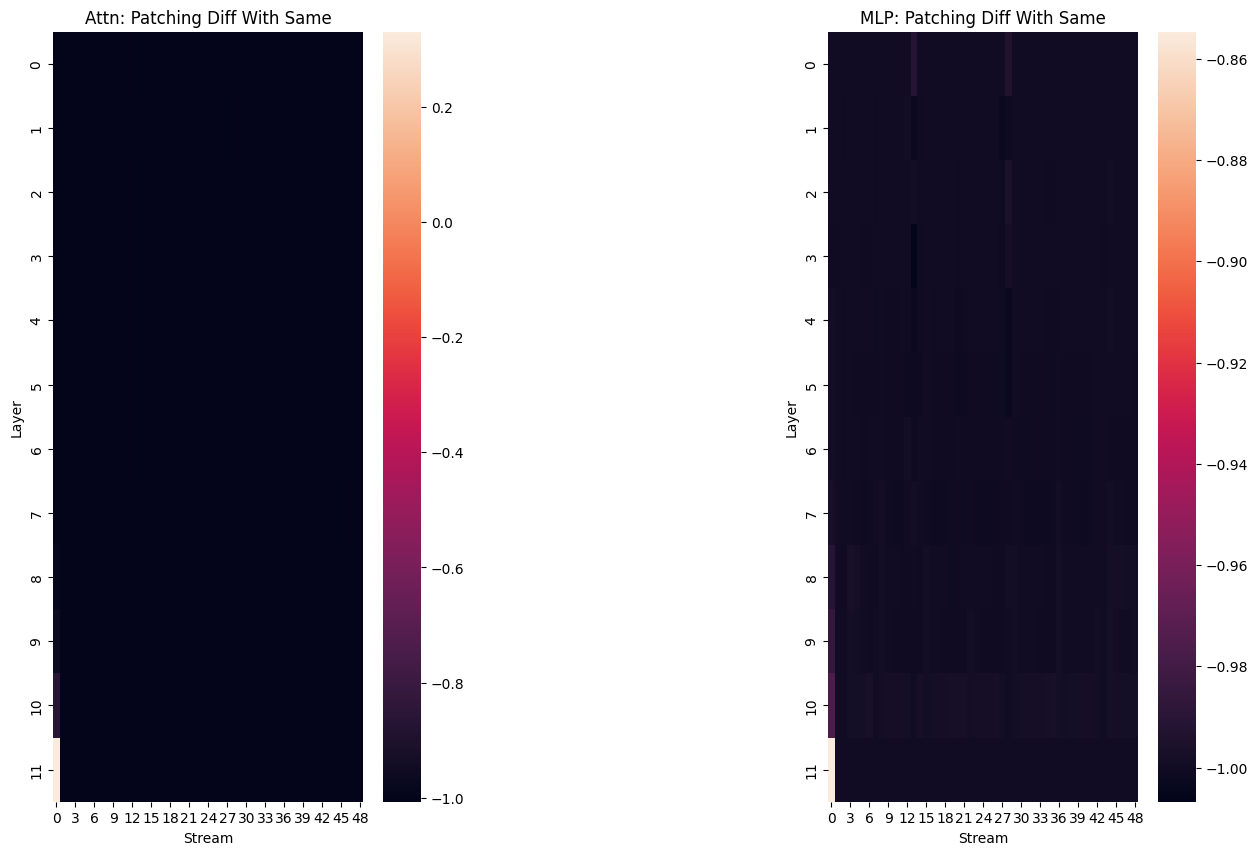

In [113]:
layer_patching(diff, "Patching Diff With Same", same_cache)

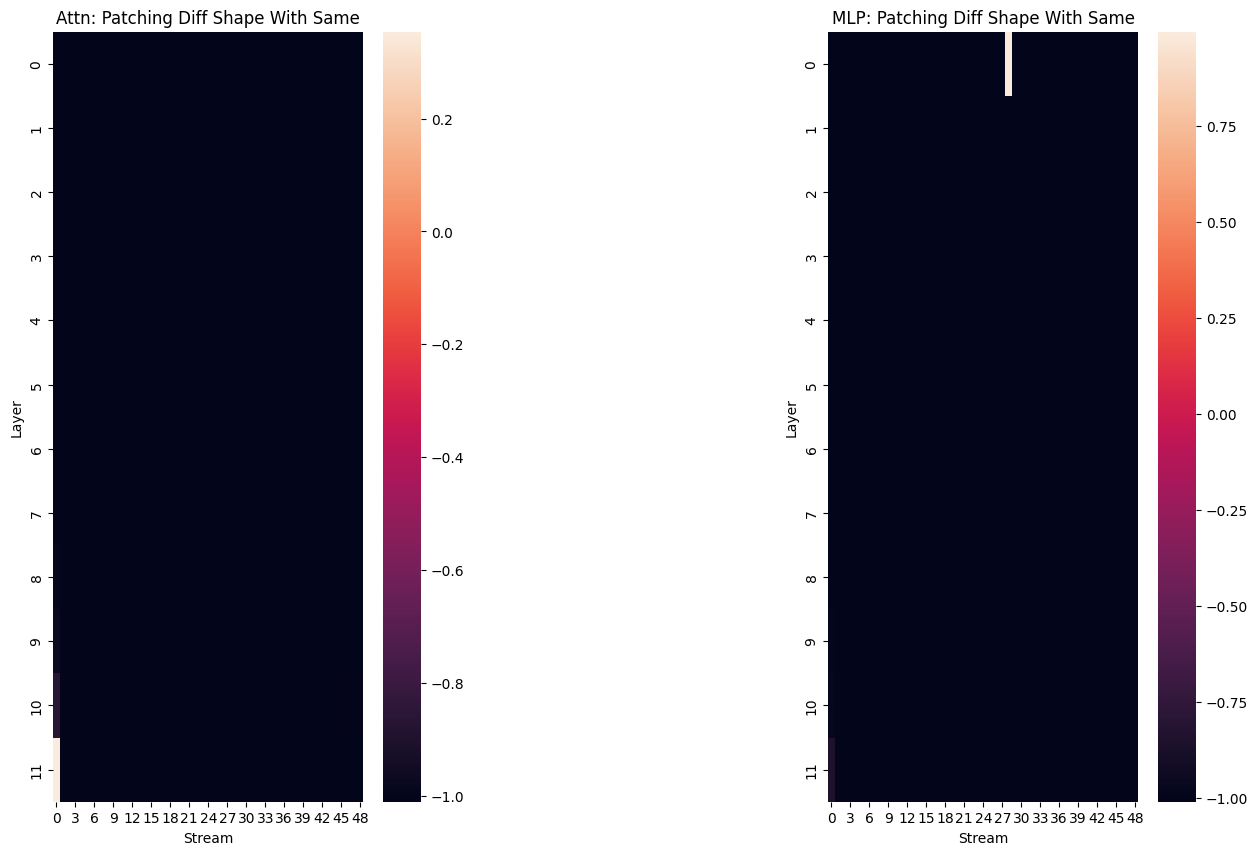

In [114]:
layer_patching(corrupt_shape, "Patching Diff Shape With Same", same_cache)

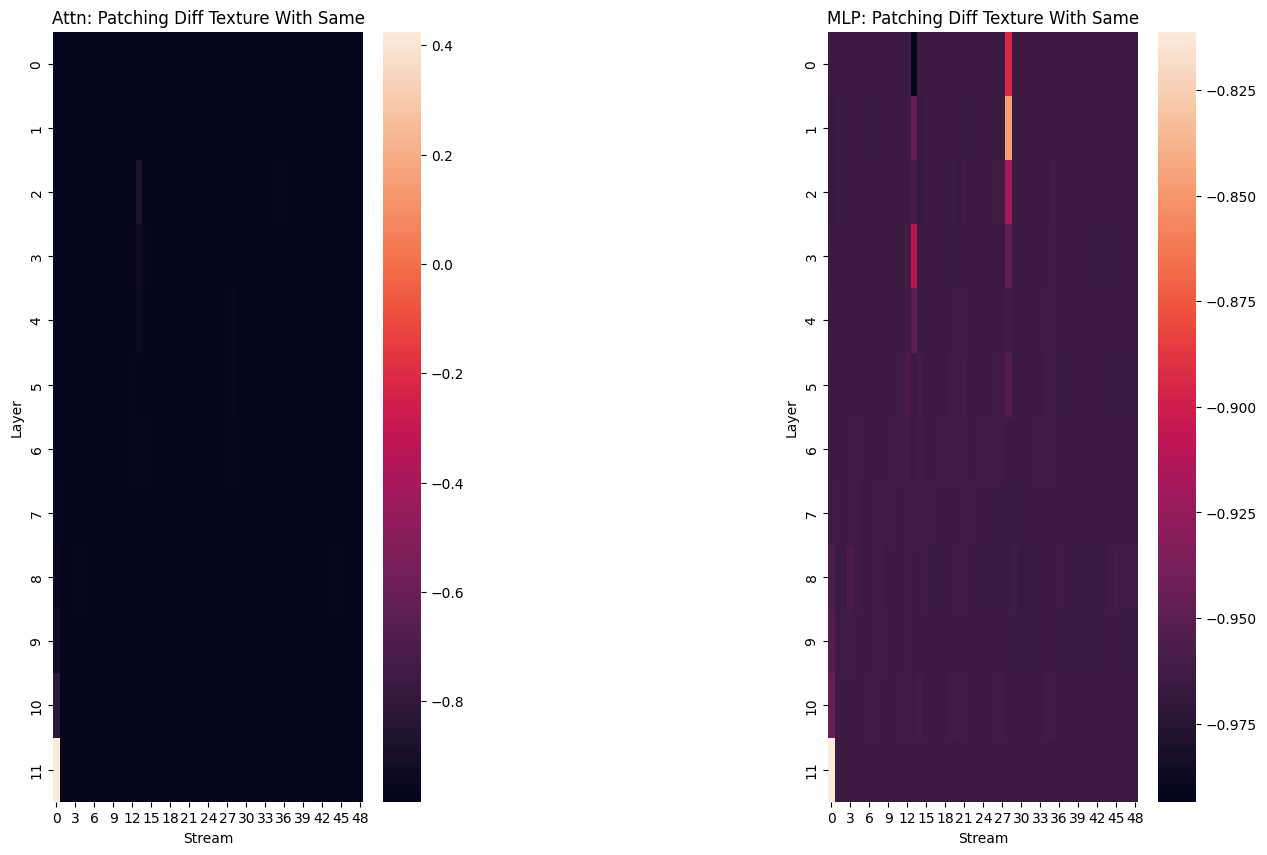

In [115]:
layer_patching(corrupt_texture, "Patching Diff Texture With Same", same_cache)

## Patching Ablation

## Residual Stream Ablation

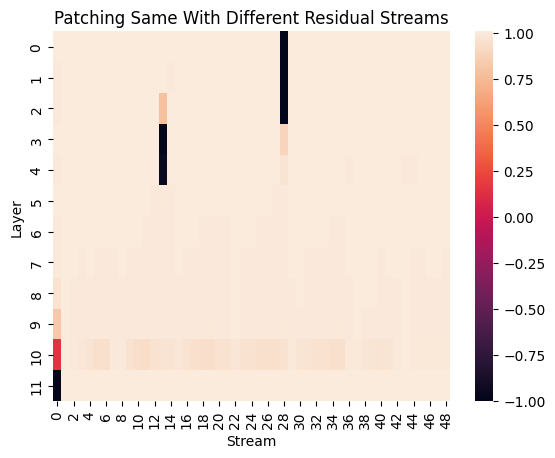

In [116]:
resid_patching(same, "Patching Same With Different Residual Streams", diff_cache)

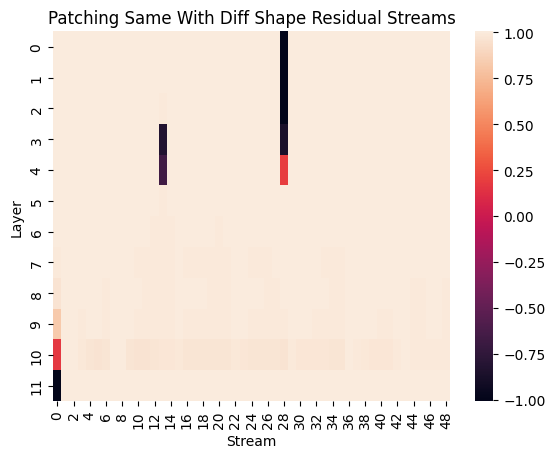

In [118]:
resid_patching(same, "Patching Same With Diff Shape Residual Streams", diff_shape_cache)

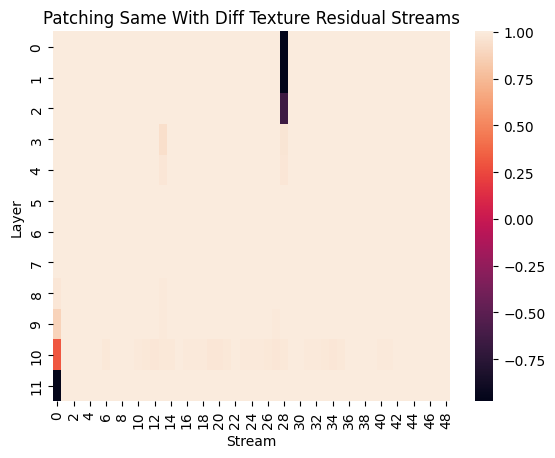

In [120]:
resid_patching(same, "Patching Same With Diff Texture Residual Streams", diff_texture_cache)

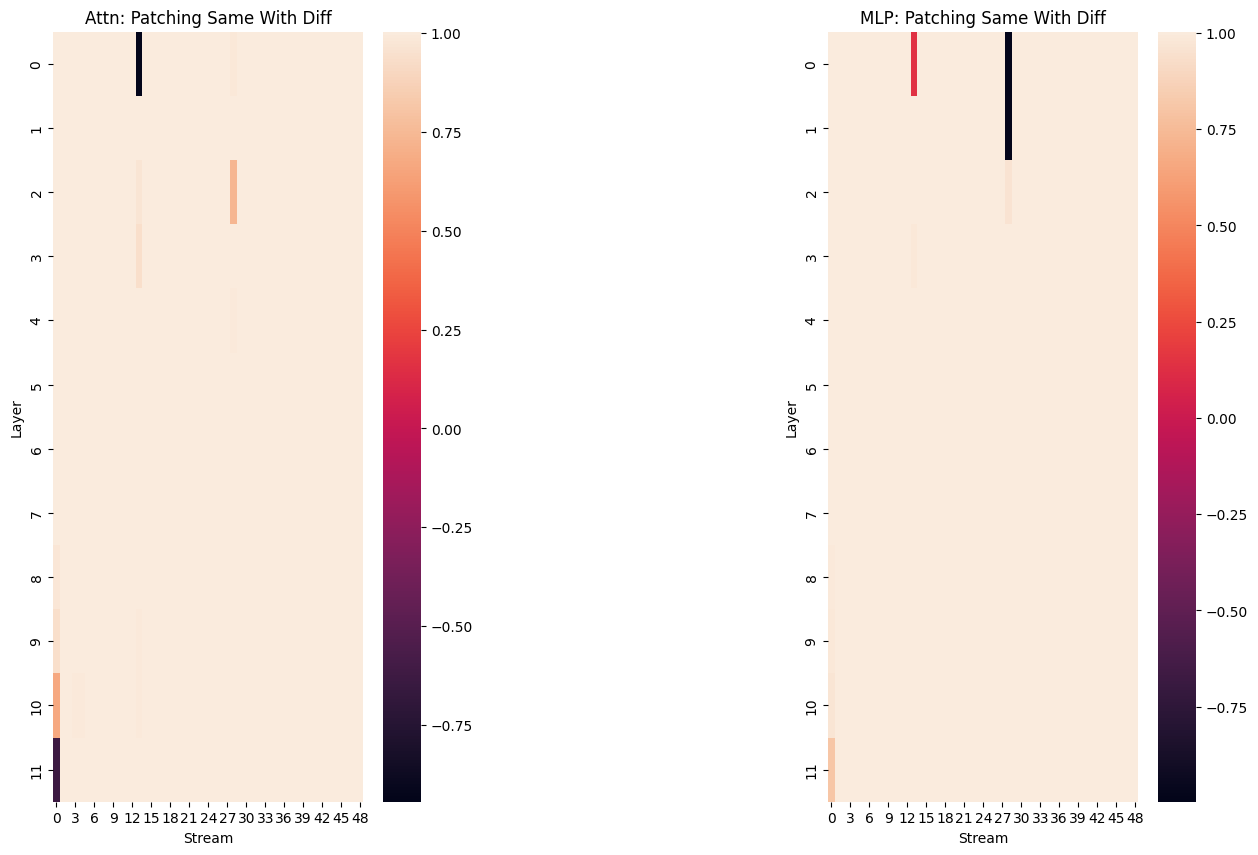

In [121]:
layer_patching(same, "Patching Same With Diff", diff_cache)

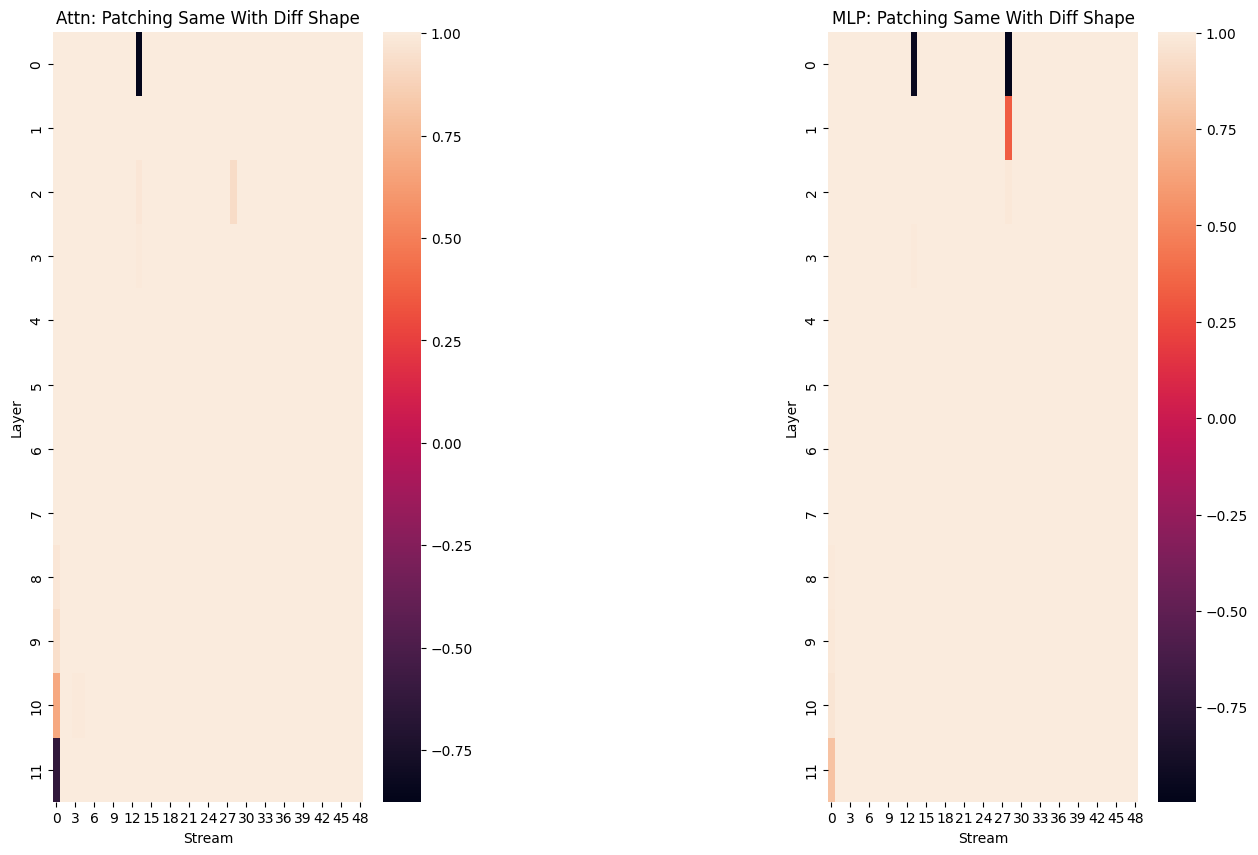

In [122]:
layer_patching(same, "Patching Same With Diff Shape", diff_shape_cache)

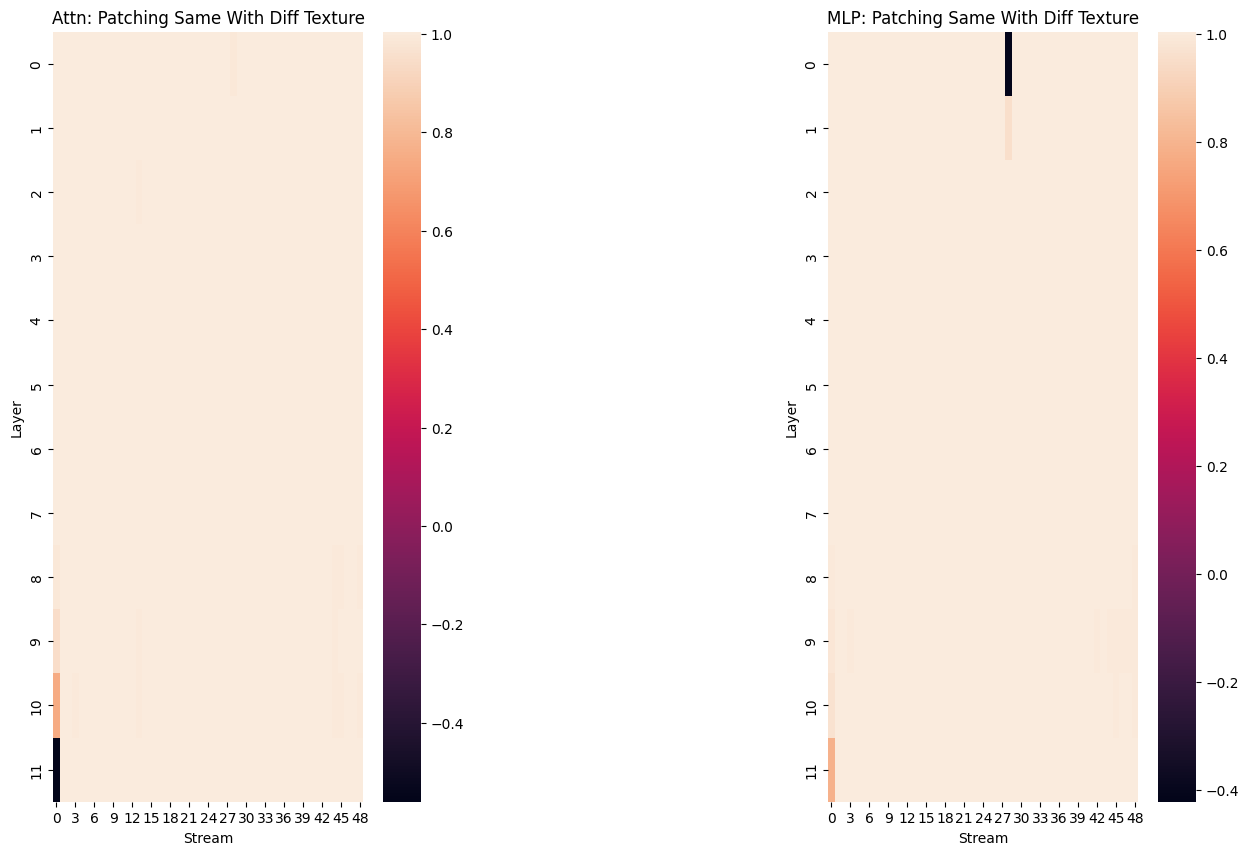

In [123]:
layer_patching(same, "Patching Same With Diff Texture", diff_texture_cache)

# Repeat with From Scratch Model

In [114]:
hf_model.load_state_dict(torch.load("../models/scratch_vit32/opowhyqw.pth"))
state_dict = convert_vit_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'blocks.9.attn.mask', 'blocks.9.attn.IGNORE', 'blocks.10.attn.mask', 'blocks.10.attn.IGNORE', 'blocks.11.attn.mask', 'blocks.11.attn.IGNORE'], unexpected_keys=[])

In [116]:
im_path_same = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/same/0.png"
im_path_diff = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different/0.png"
im_path_diff_shape = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-shape/0.png"
im_path_diff_texture = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-texture/0.png"

same = Image.open(im_path_same)
diff = Image.open(im_path_diff)
corrupt_shape = Image.open(im_path_diff_shape)
corrupt_texture = Image.open(im_path_diff_texture)

same = image_processor.preprocess(np.array(same, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
diff = image_processor.preprocess(np.array(diff, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_shape = image_processor.preprocess(np.array(corrupt_shape, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_texture = image_processor.preprocess(np.array(corrupt_texture, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

In [117]:
print(f"Same Logits: {tl_model(same)}")
print(f"Different Logits: {tl_model(diff)}")
print(f"Different-Shape Logits: {tl_model(corrupt_shape)}")
print(f"Different-Texture Logits: {tl_model(corrupt_texture)}")

Same Logits: tensor([[-4.4890,  4.8168]], device='cuda:0')
Different Logits: tensor([[ 5.4920, -5.0607]], device='cuda:0')
Different-Shape Logits: tensor([[ 5.8377, -5.4048]], device='cuda:0')
Different-Texture Logits: tensor([[ 6.1744, -5.5942]], device='cuda:0')


In [118]:
same_logits, same_cache = tl_model.run_with_cache(same)
diff_logits, diff_cache = tl_model.run_with_cache(diff)
_, diff_shape_cache = tl_model.run_with_cache(corrupt_shape)
_, diff_texture_cache = tl_model.run_with_cache(corrupt_texture)

In [119]:
def get_score(patch_logits, same_logits=same_logits, diff_logits=diff_logits):
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    diff_logits_diff = diff_logits[0, 1] - diff_logits[0, 0]
    patched_logits_diff = patch_logits[0, 1] - patch_logits[0, 0]

    return 2 * (patched_logits_diff - diff_logits_diff)/(same_logits_diff - diff_logits_diff) - 1

## Activation Patching

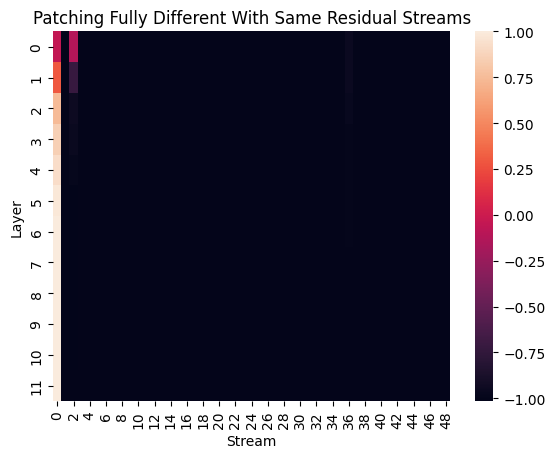

In [120]:
resid_patching(diff, "Patching Fully Different With Same Residual Streams", same_cache)

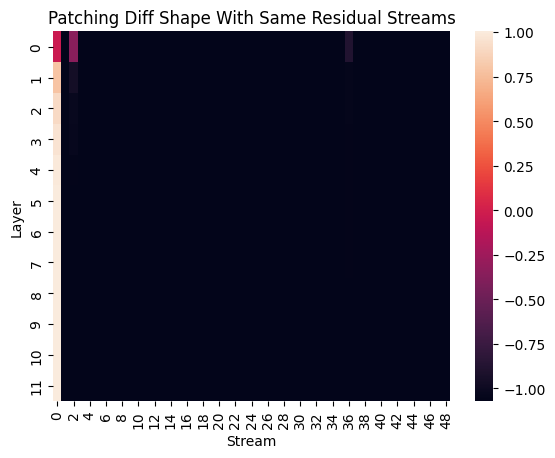

In [121]:
resid_patching(corrupt_shape, "Patching Diff Shape With Same Residual Streams", same_cache)

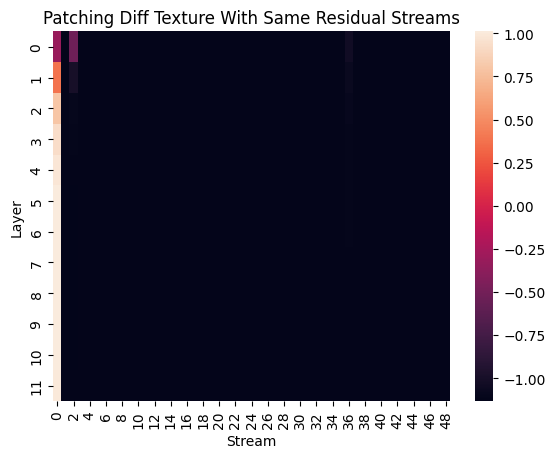

In [122]:
resid_patching(corrupt_texture, "Patching Diff Texture With Same Residual Streams", same_cache)

## Linear Subspace Analysis

### Texture

In [124]:
import os
import pickle as pkl

torch.set_grad_enabled(False)

set_dir = "../stimuli/Interventions/Texture_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

In [125]:
base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

texture_1_group = []
texture_2_group = []

for i in range(16):
    path = f"Texture_1_{i}.png"
    texture_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Texture_2_{i}.png"
    texture_2_group.append(Image.open(os.path.join(set_dir, path)))

texture_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_1_group]
texture_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_2_group]

In [126]:
base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as different!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

tensor([[ 3.4372, -4.0256]], device='cuda:0')
Model identifies these objects as different!
tensor([[-4.5020,  3.8887]], device='cuda:0')
Model identifies these objects as same!


In [127]:
from collections import defaultdict
layer2vec1 = create_mean_cache(texture_1_group)
layer2vec2 = create_mean_cache(texture_2_group)

In [128]:
layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

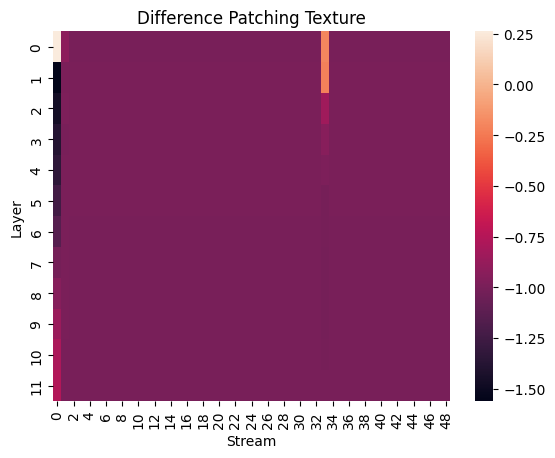

In [129]:
diffs = diff_patching(base, "Difference Patching Texture", layer2diff)

### Shape

In [132]:
set_dir = "../stimuli/Interventions/Shape_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

shape_1_group = []
shape_2_group = []

for i in range(16):
    path = f"Shape_1_{i}.png"
    shape_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Shape_2_{i}.png"
    shape_2_group.append(Image.open(os.path.join(set_dir, path)))

shape_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_1_group]
shape_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_2_group]

In [133]:
base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as different!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

tensor([[ 5.0336, -4.1400]], device='cuda:0')
Model identifies these objects as different!
tensor([[-5.2404,  4.1795]], device='cuda:0')
Model identifies these objects as same!


In [134]:
layer2vec1 = create_mean_cache(shape_1_group)
layer2vec2 = create_mean_cache(shape_2_group)

In [135]:
layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

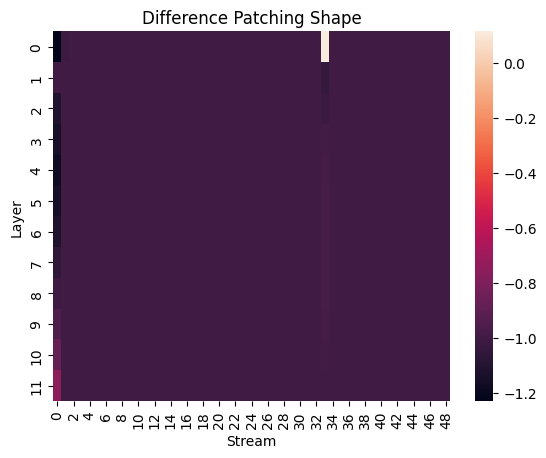

In [136]:
diffs = diff_patching(base, "Difference Patching Shape", layer2diff)

## Layer by Layer

In [123]:
layer_patching(diff, "Patching Diff With Same", same_cache)

NameError: name 'layer_patching' is not defined

In [ ]:
layer_patching(corrupt_shape, "Patching Diff Shape With Same", same_cache)

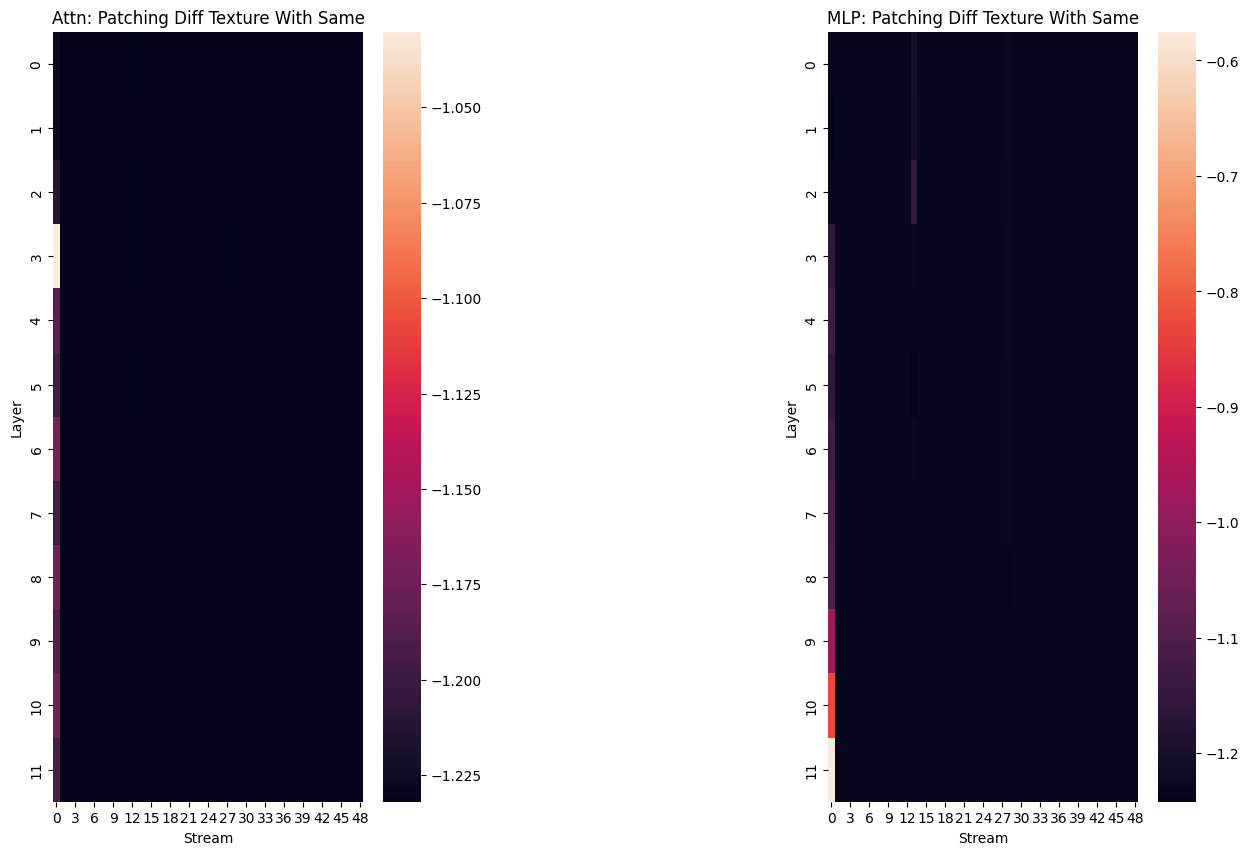

In [140]:
layer_patching(corrupt_texture, "Patching Diff Texture With Same", same_cache)

## Ablation

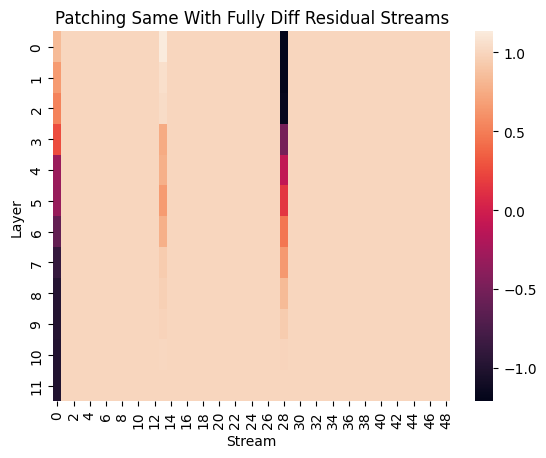

In [134]:
resid_patching(same, "Patching Same With Fully Diff Residual Streams", diff_cache)

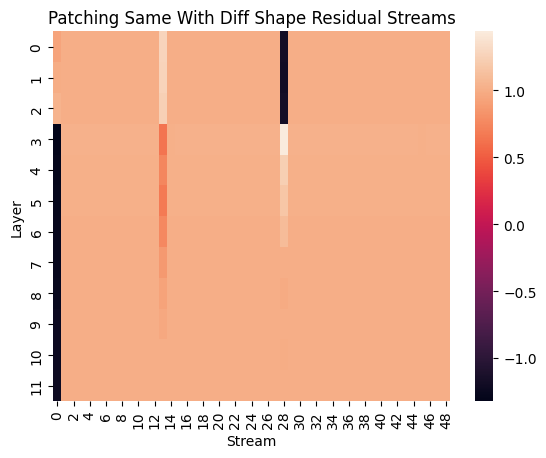

In [129]:
resid_patching(same, "Patching Same With Diff Shape Residual Streams", diff_shape_cache)

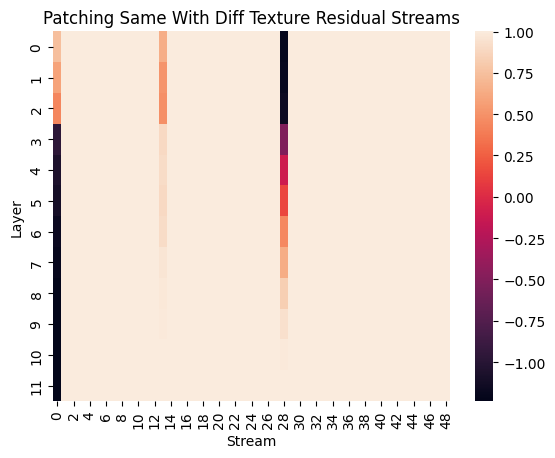

In [130]:
resid_patching(same, "Patching Same With Diff Texture Residual Streams", diff_texture_cache)

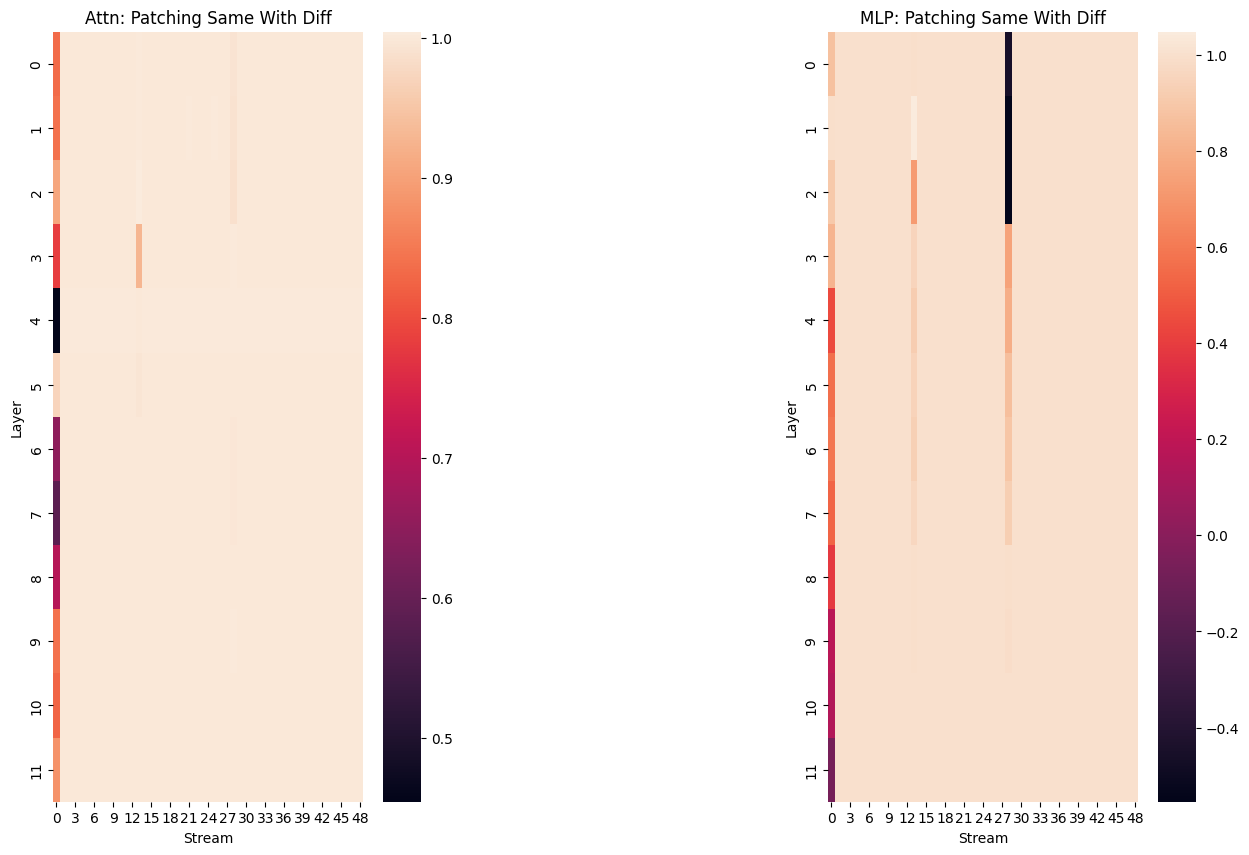

In [131]:
layer_patching(same, "Patching Same With Diff", diff_cache)

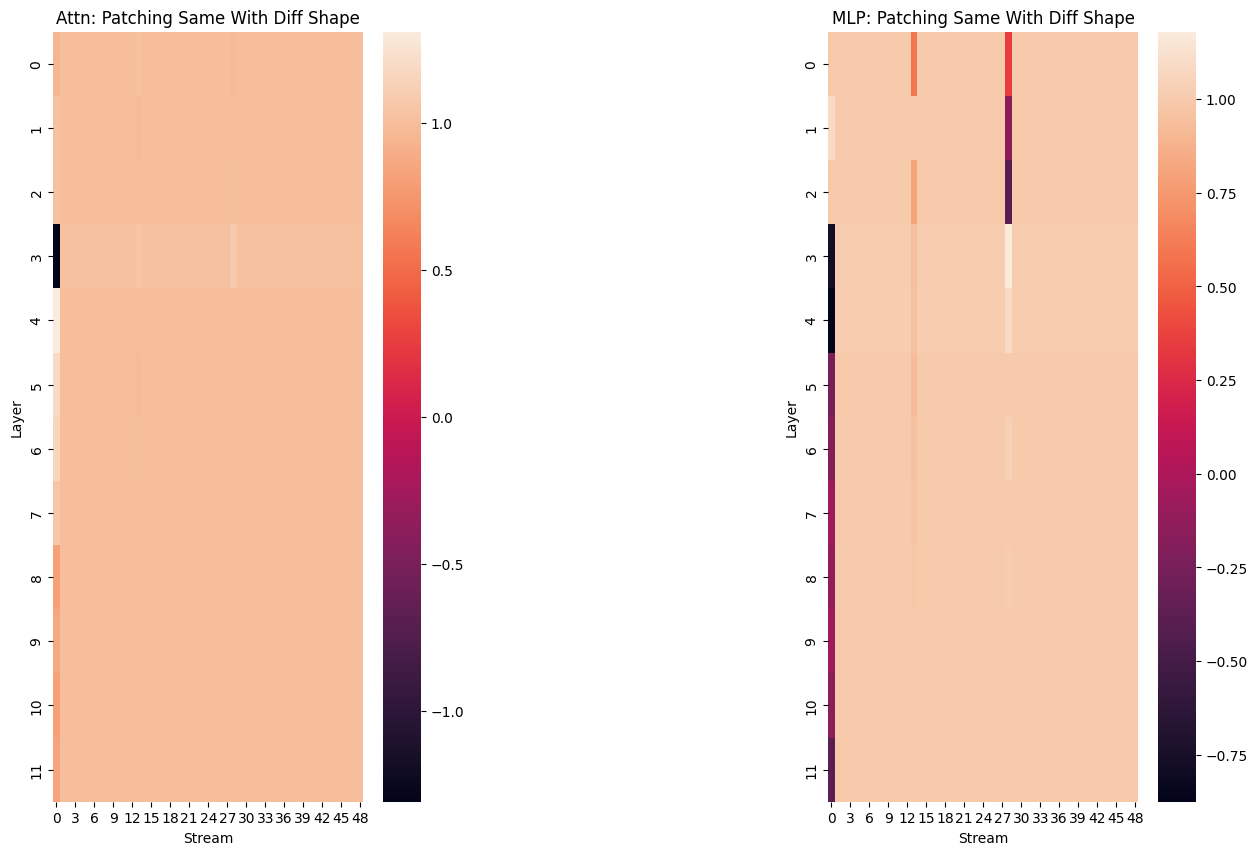

In [132]:
layer_patching(same, "Patching Same With Diff Shape", diff_shape_cache)

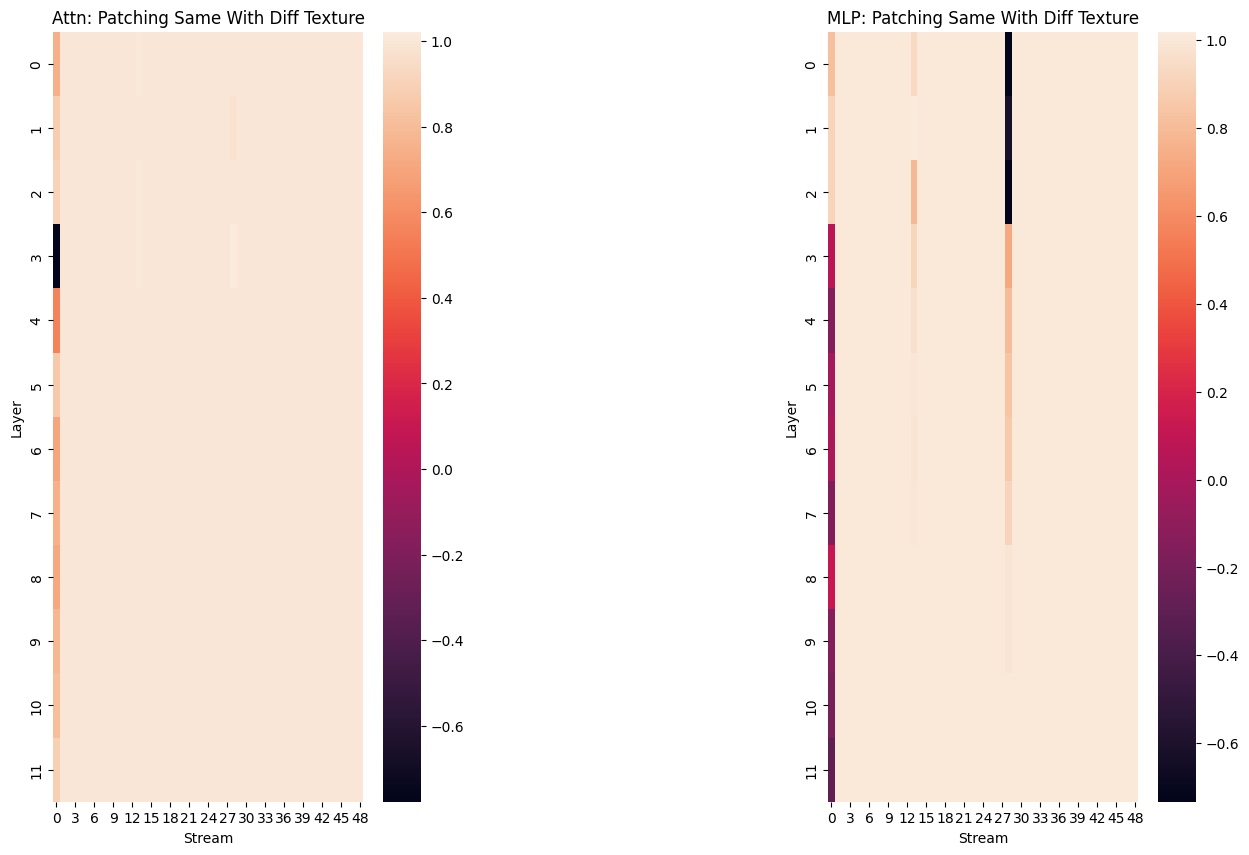

In [133]:
layer_patching(same, "Patching Same With Diff Texture", diff_texture_cache)

# Do the same with CLIP

In [3]:
from transformers import AutoProcessor, CLIPVisionModelWithProjection, CLIPVisionConfig
from transformer_lens.HookedViT import HookedViT
from transformer_lens.components import ViTHead
import torch.nn as nn
import torch

image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32").image_processor
cfg = CLIPVisionConfig.from_pretrained("openai/clip-vit-base-patch32")
hf_model = CLIPVisionModelWithProjection(cfg).to("cuda")
hf_model.visual_projection = nn.Linear(cfg.hidden_size, 2, bias=True)

hf_model.load_state_dict(torch.load("../models/clip_vit32/ypbw3zep.pth"))

from transformer_lens.loading_from_pretrained import convert_clip_weights

tl_model = HookedViT.from_pretrained("openai/clip-vit-base-patch32", is_clip=True, force_projection_bias=True)
tl_model.cfg.num_labels = 2
tl_model.classifier_head = ViTHead(tl_model.cfg)
tl_model.to("cuda")

state_dict = convert_clip_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.
/gpfs/data/epavlick/mlepori/miniconda3/envs/relational-circuits/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Moving model to device:  cuda
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
Moving model to device:  cuda


_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'blocks.9.attn.mask', 'blocks.9.attn.IGNORE', 'blocks.10.attn.mask', 'blocks.10.attn.IGNORE', 'blocks.11.attn.mask', 'blocks.11.attn.IGNORE'], unexpected_keys=[])

## Load Data

In [4]:
im_path_same = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/same/0.png"
im_path_diff = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different/0.png"
im_path_diff_shape = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-shape/0.png"
im_path_diff_texture = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-texture/0.png"

In [5]:
from PIL import Image
import numpy as np

In [6]:
same = Image.open(im_path_same)
diff = Image.open(im_path_diff)
corrupt_shape = Image.open(im_path_diff_shape)
corrupt_texture = Image.open(im_path_diff_texture)

same = image_processor.preprocess(np.array(same, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
diff = image_processor.preprocess(np.array(diff, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_shape = image_processor.preprocess(np.array(corrupt_shape, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_texture = image_processor.preprocess(np.array(corrupt_texture, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

In [7]:
torch.set_grad_enabled(False)

In [8]:
same_logits, same_cache = tl_model.run_with_cache(same)
diff_logits, diff_cache = tl_model.run_with_cache(diff)
_, diff_shape_cache = tl_model.run_with_cache(corrupt_shape)
_, diff_texture_cache = tl_model.run_with_cache(corrupt_texture)

In [14]:
num_patches = same_cache['embed.hook_embed'].shape[1]

In [9]:
def get_score(patch_logits, same_logits=same_logits, diff_logits=diff_logits):
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    diff_logits_diff = diff_logits[0, 1] - diff_logits[0, 0]
    patched_logits_diff = patch_logits[0, 1] - patch_logits[0, 0]

    return 2 * (patched_logits_diff - diff_logits_diff)/(same_logits_diff - diff_logits_diff) - 1

## Activation Patching

In [10]:
print(f"Same Logits: {tl_model(same)}")
print(f"Different Logits: {tl_model(diff)}")
print(f"Different-Shape Logits: {tl_model(corrupt_shape)}")
print(f"Different-Texture Logits: {tl_model(corrupt_texture)}")

Same Logits: tensor([[-5.2287,  5.9966]], device='cuda:0')
Different Logits: tensor([[ 5.1921, -6.4405]], device='cuda:0')
Different-Shape Logits: tensor([[ 4.9954, -6.3640]], device='cuda:0')
Different-Texture Logits: tensor([[ 4.7450, -6.0101]], device='cuda:0')


In [11]:
from jaxtyping import Float
from functools import partial
import transformer_lens.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def patch_residual_component(
    target_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    source_cache,
):
    target_residual_component[:, pos, :] = source_cache[hook.name][:, pos, :]
    return target_residual_component

def resid_patching(target_image, title, source_cache):
    patched_residual_stream_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for position in range(num_patches):
            hook_fn = partial(patch_residual_component, pos=position, source_cache=source_cache)
            patched_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )
            patched_residual_stream_diff[layer, position] = get_score(patched_logits)
    s =sns.heatmap(patched_residual_stream_diff.cpu())
    s.set_title(title)
    s.set(xlabel='Stream', ylabel='Layer')

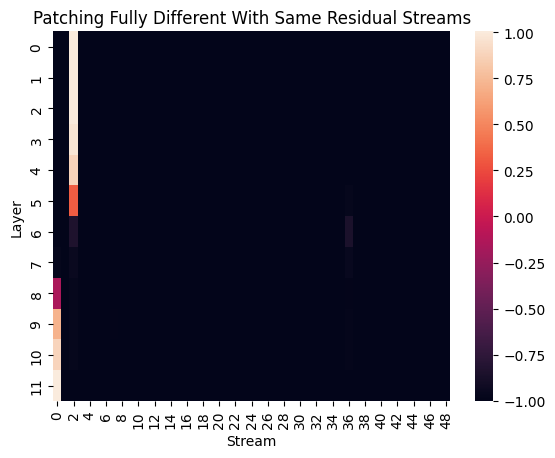

In [15]:
resid_patching(diff, "Patching Fully Different With Same Residual Streams", same_cache)

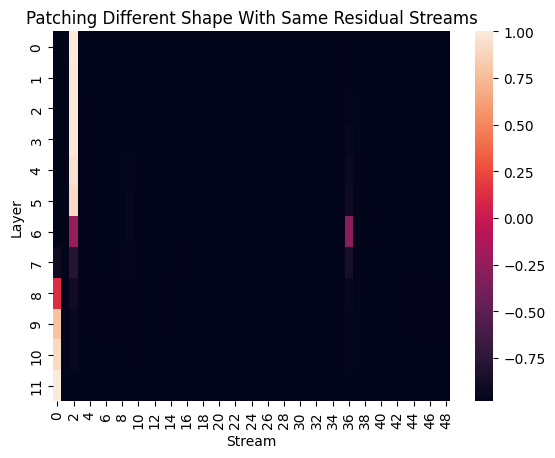

In [16]:
resid_patching(corrupt_shape, "Patching Different Shape With Same Residual Streams", same_cache)

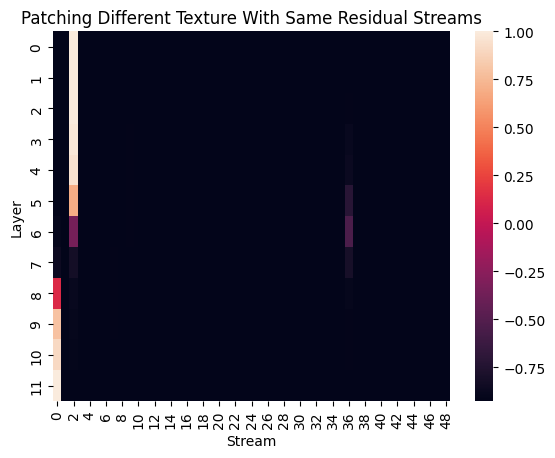

In [17]:
resid_patching(corrupt_texture, "Patching Different Texture With Same Residual Streams", same_cache)

## Linear Subspace Analysis

#### Texture

tensor([[-4.2791,  4.7495]], device='cuda:0')
Model identifies these objects as the same! This is different than the other models!
tensor([[-5.3943,  5.9690]], device='cuda:0')
Model identifies these objects as same!


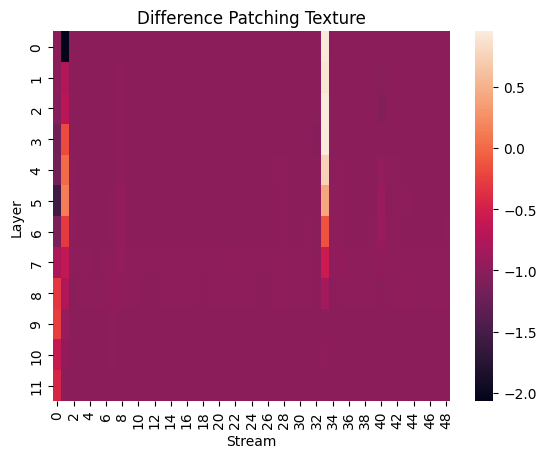

In [20]:
import os
import pickle as pkl

torch.set_grad_enabled(False)

set_dir = "../stimuli/Interventions/Texture_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

texture_1_group = []
texture_2_group = []

for i in range(16):
    path = f"Texture_1_{i}.png"
    texture_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Texture_2_{i}.png"
    texture_2_group.append(Image.open(os.path.join(set_dir, path)))

texture_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_1_group]
texture_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in texture_2_group]

base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as the same! This is different than the other models!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

#### Compute two texture vectors

resid_position = base_dict["stream_idx_2"] + 1 # +1 because of cls token
resid_position

#### Texture Vectors

def create_mean_cache(im_group):
    layer2vec = defaultdict(lambda: defaultdict(list))
    for im in im_group:
        _, cache = tl_model.run_with_cache(im)
        for layer in range(tl_model.cfg.n_layers):
            for pos in range(num_patches):
                layer2vec[layer][pos].append(cache[utils.get_act_name("resid_post", layer)][0][pos])
    
    for layer in range(tl_model.cfg.n_layers):
        for pos in range(num_patches):
            layer2vec[layer][pos] = torch.mean(torch.stack(layer2vec[layer][pos]), dim=0)
    return layer2vec

from collections import defaultdict
layer2vec1 = create_mean_cache(texture_1_group)
layer2vec2 = create_mean_cache(texture_2_group)

#### Create Difference Vectors

layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

def patch_diff_vectors(
    target_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    diff_vec,
):
    target_residual_component[:, pos, :] += diff_vec
    return target_residual_component

def diff_patching(target_image, title, layer2diff):
    patched_residual_stream_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for pos in range(num_patches):
            hook_fn = partial(patch_diff_vectors, pos=pos, diff_vec=layer2diff[layer][pos])
            patched_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )
            patched_residual_stream_diff[layer][pos] = get_score(patched_logits, same_logits=same_logits, diff_logits=base_logits)
    s =sns.heatmap(patched_residual_stream_diff.cpu())
    s.set_title(title)
    s.set(xlabel='Stream', ylabel='Layer')
    return patched_residual_stream_diff

diffs = diff_patching(base, "Difference Patching Texture", layer2diff)

#### Shape

tensor([[ 5.1182, -6.4726]], device='cuda:0')
Model identifies these objects as different!
tensor([[-5.3600,  5.9529]], device='cuda:0')
Model identifies these objects as same!


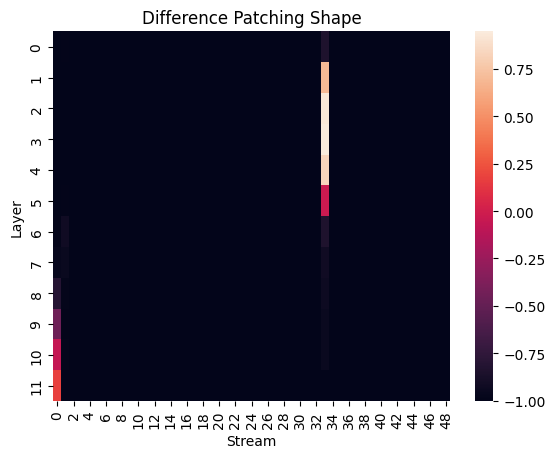

In [19]:
set_dir = "../stimuli/Interventions/Shape_Subspace_Set1"
base_dict = pkl.load(open(os.path.join(set_dir, "base.pkl"), "rb"))

base = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "base.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
same = image_processor.preprocess(np.array(Image.open(os.path.join(set_dir, "same.png")), dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

shape_1_group = []
shape_2_group = []

for i in range(16):
    path = f"Shape_1_{i}.png"
    shape_1_group.append(Image.open(os.path.join(set_dir, path)))
    path = f"Shape_2_{i}.png"
    shape_2_group.append(Image.open(os.path.join(set_dir, path)))

shape_1_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_1_group]
shape_2_group = [image_processor.preprocess(np.array(im, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda") for im in shape_2_group]

base_logits, base_cache = tl_model.run_with_cache(base)
print(base_logits)
print("Model identifies these objects as different!")

same_logits, same_cache = tl_model.run_with_cache(same)
print(same_logits)
print("Model identifies these objects as same!")

layer2vec1 = create_mean_cache(shape_1_group)
layer2vec2 = create_mean_cache(shape_2_group)

layer2diff = defaultdict(dict)
for layer in range(tl_model.cfg.n_layers):
    for pos in range(num_patches):
        layer2diff[layer][pos] = layer2vec1[layer][pos] - layer2vec2[layer][pos]

diffs = diff_patching(base, "Difference Patching Shape", layer2diff)